In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mannwhitneyu
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [3]:
all_features = list(test.columns)

In [4]:
train['Target'].value_counts()

Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

In [5]:
label_encoder = LabelEncoder()
train['Target'] = label_encoder.fit_transform(train['Target'])

In [6]:
train['Target'].value_counts()

Target
2    36282
0    25296
1    14940
Name: count, dtype: int64

In [7]:
len(np.unique(train['Target'].value_counts()))

3

In [8]:
cat_features, num_features = [], []

for feature in all_features[1:]:
    if len(np.unique(train[feature])) < 50:
        cat_features.append(feature)
    else:
        num_features.append(feature)

In [9]:
cat_features

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

In [10]:
num_features

['Previous qualification (grade)',
 "Father's occupation",
 'Admission grade',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (grade)']

In [11]:
num_features = [
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]

cat_features = [
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'Age at enrollment',
    'International',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (without evaluations)',
]

In [12]:
for i in all_features:
    if i not in cat_features + num_features:
        print(i)

id


In [13]:
for feature in cat_features:
    dtype = pd.CategoricalDtype(categories=list(set(train[feature]) | set(test[feature])), ordered=False)
    for df in [train, test]:
        df[feature] = df[feature].astype(dtype)

# Comparing train, test and the original data

A standard question in Kaggle playground competitions is whether the three datasets train, test and original have the same distributions. The question can be answered informally by histograms of a single feature:
- In a comparison between training data and original data, the leftmost bar of the histogram shows that they have different unconditional distributions (the conditional target distributions may still be the same, though).
- The distributions of train and test are almost the same.

More formally, we can compare the distributions with a [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test). The low pvalue for the original dataset indicates that the distributions are different. The pvalue for the test dataset is 0.06, which means we shouldn't reject the null hypothesis that the train and test distributions are the same.

In [14]:
print('Mann–Whitney U test comparing train and test datasets')
print(mannwhitneyu(train['Curricular units 2nd sem (grade)'],
                   test['Curricular units 2nd sem (grade)']))
print('\nMann–Whitney U test comparing train and test datasets')
print(mannwhitneyu(train['International'],
                   test['International']))
print('\nMann–Whitney U test comparing train and test datasets')
print(mannwhitneyu(train['Curricular units 1st sem (grade)'],
                   test['Curricular units 1st sem (grade)']))

Mann–Whitney U test comparing train and test datasets
MannwhitneyuResult(statistic=1939815047.0, pvalue=0.06384029023546983)

Mann–Whitney U test comparing train and test datasets
MannwhitneyuResult(statistic=1953313245.0, pvalue=0.06211153131162807)

Mann–Whitney U test comparing train and test datasets
MannwhitneyuResult(statistic=1932853257.0, pvalue=0.003337222164171134)


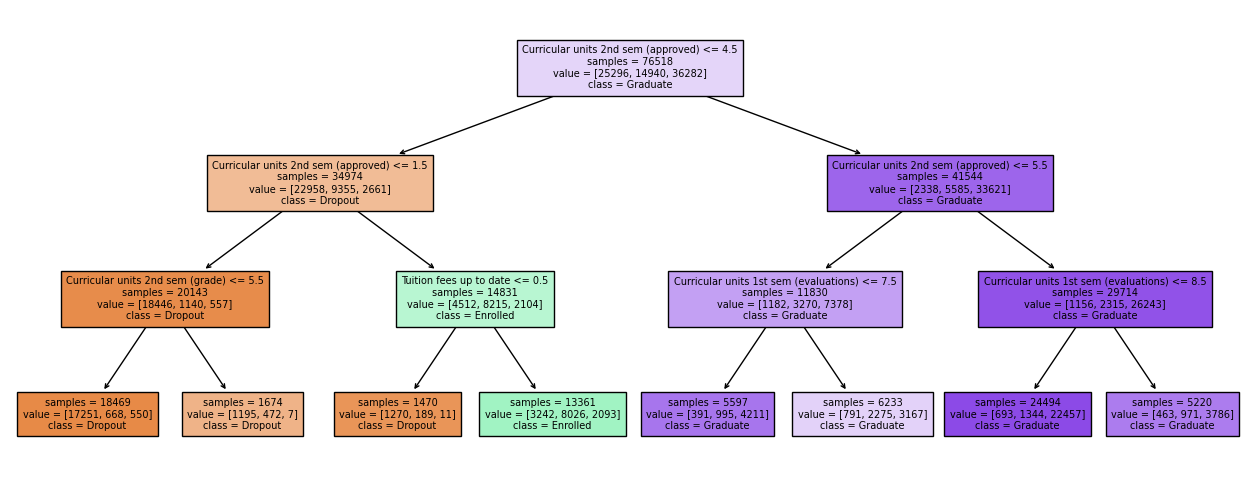

In [15]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(train[all_features], train.Target);

plt.figure(figsize=(16, 6))
plot_tree(dt, feature_names=all_features, class_names=label_encoder.classes_, fontsize=7, impurity=False, filled=True, ax=plt.gca())
plt.show()

##### These are the 2 most important features:

- Curricular units 2nd sem (approved)
- Curricular units 1st sem (evaluations)



## Modeling Time!

In [16]:
X_train = train.drop(columns=['id', 'Target'])
y_train = train['Target']

In [17]:
X_test = test.drop(columns=['id'])

In [18]:
# Function to perform cross-validation
def cross_validate_model(model, name, X, y):
    results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)
    print(f"{name}: accuracy={results['test_accuracy'].mean():.5f}")

scoring = {
    'accuracy': make_scorer(accuracy_score)
#     'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

In [19]:
model_lgbm_0 = LGBMClassifier(verbose=-1)
cross_validate_model(model_lgbm_0, 'LightGBM-0', X_train, y_train)

LightGBM-0: accuracy=0.83107


In [20]:
model_lgbm_0.fit(X_train, y_train)

LGBMClassifier(verbose=-1)

In [22]:
test_ids = test['id']
X_test = test.drop(columns=['id'])
y_pred_test = model_lgbm_0.predict(X_test)

label_mapping = {2: 'Graduate', 0: 'Dropout', 1: 'Enrolled'}
mapped_predictions = [label_mapping[pred] for pred in y_pred_test]

submission_df = pd.DataFrame({'id': test_ids,
                              'Target': mapped_predictions})

submission_df.to_csv('submission.csv', index=False)